## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V/view?usp=sharing
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 13.0MB/s]


## **1. Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Read dataset**

In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

## **3. Train/val/test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


## **4. Data Normalization**

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train,dtype=torch.float32).to(device)
y_train = torch.tensor(y_train,dtype=torch.long).to(device)
X_val = torch.tensor(X_val,dtype=torch.float32).to(device)
y_val = torch.tensor(y_val,dtype=torch.long).to(device)
X_test = torch.tensor(X_test,dtype=torch.float32).to(device)
y_test = torch.tensor(y_test,dtype=torch.long).to(device)

## **5. Create PyTorch DataLoader**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

## **6. Build MLP network**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims,hidden_dims)
        self.output = nn.Linear(hidden_dims,output_dims)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512

model = MLP(input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)


In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

## **7. Training**

In [ ]:
def compute_accuracy(y_hat, y_true):
    _,y_hat = torch.max(y_hat,dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []


for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.997	Validation loss: 1.317

EPOCH 2:	Training loss: 0.875	Validation loss: 1.102

EPOCH 3:	Training loss: 0.961	Validation loss: 1.094

EPOCH 4:	Training loss: 0.888	Validation loss: 1.538

EPOCH 5:	Training loss: 0.850	Validation loss: 0.850

EPOCH 6:	Training loss: 0.705	Validation loss: 0.808

EPOCH 7:	Training loss: 0.732	Validation loss: 1.524

EPOCH 8:	Training loss: 0.776	Validation loss: 0.886

EPOCH 9:	Training loss: 0.711	Validation loss: 0.794

EPOCH 10:	Training loss: 0.752	Validation loss: 0.789

EPOCH 11:	Training loss: 0.772	Validation loss: 1.205

EPOCH 12:	Training loss: 0.717	Validation loss: 0.792

EPOCH 13:	Training loss: 0.640	Validation loss: 0.753

EPOCH 14:	Training loss: 0.680	Validation loss: 0.950

EPOCH 15:	Training loss: 0.630	Validation loss: 0.717

EPOCH 16:	Training loss: 0.578	Validation loss: 0.935

EPOCH 17:	Training loss: 0.592	Validation loss: 0.740

EPOCH 18:	Training loss: 0.604	Validation loss: 0.615

EPOCH 19:	Training

## **8. Evaluation**

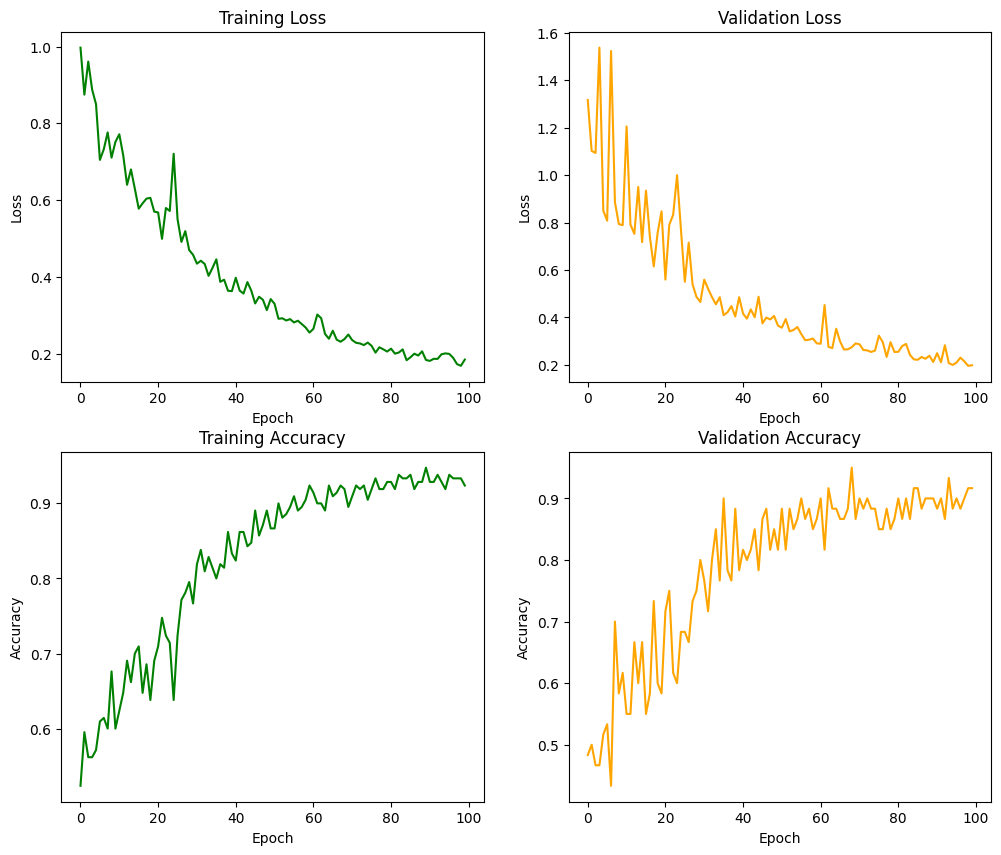

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {test_acc}')

Evaluation on val set:
Accuracy: 0.9333333333333333
